In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("..")

import slicer
from slicer import models

N_MINIBATCH = 64
N_EPOCHS = 20

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Read Data

In [2]:
X_train = np.load("../data/X_train.npy").reshape(-1, 80, 322, 1)
Y_train = np.load("../data/Y_train.npy")
W_train = np.load("../data/W_train.npy")

X_test = np.load("../data/X_test.npy").reshape(-1, 80, 322, 1)
Y_test = np.load("../data/Y_test.npy")
W_test = np.load("../data/W_test.npy")

In [ ]:
max_print = 3
for idx in np.where(Y_train == 1)[0][1004:1004 + max_print]:
    print(W_train[idx])
    plt.figure()
    plt.imshow(X_train[idx].reshape(80, 322), aspect="auto")

# Train

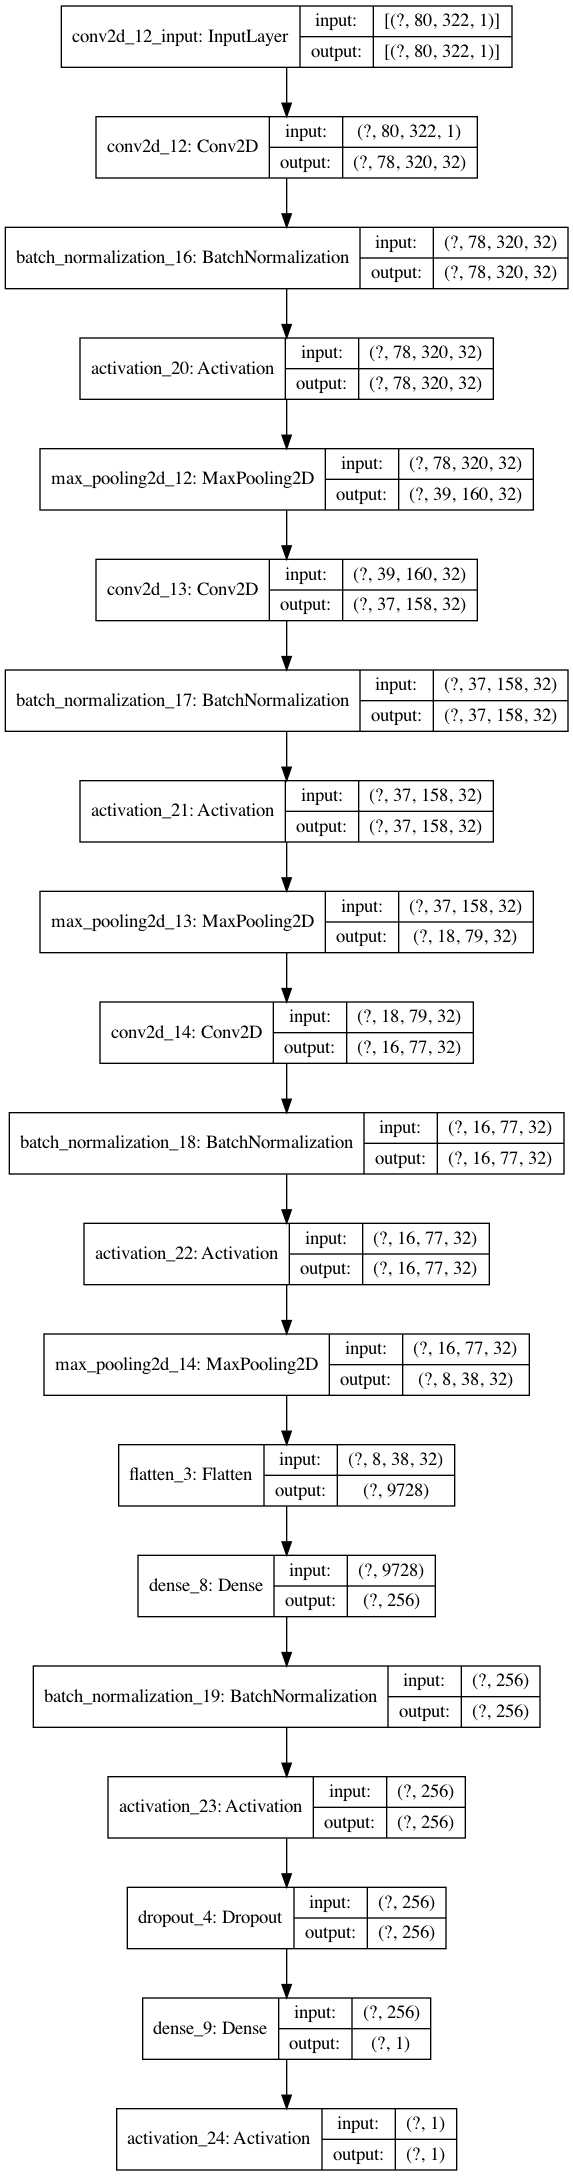

In [9]:
model = models.CNN().model

model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.Accuracy()],
)

keras.utils.plot_model(model, show_shapes=True)

In [8]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=N_MINIBATCH,
    epochs=N_EPOCHS,
    validation_data=(X_test, Y_test),
)


Train on 33784 samples, validate on 8568 samples
Epoch 1/20
15936/33784 [=============>................] - ETA: 5:09 - loss: 0.5856 - accuracy: 0.0000e+00

KeyboardInterrupt: 